# Pyro Crash Course – Notebook 3: Linear Calibration with Trainable Parameters

This notebook introduces first trainable parameters to the probabilistic model for sensor data — thereby showcasing meaningful inference with svi.

### 🔙 Quick Recap

*Notebook 2* treated $T_{\text{meas}}$ as $T_{\text{true}}$ plus fixed noise.  
No parameters ⇒ no learning.  
Today we let the model **adjust a global offset and scale** to better fit the data.


---

### 🎯 Learning Goals

- Introduce **deterministic trainable parameters** with `pyro.param`
- Use SVI to perform **Maximum Likelihood Estimation** (equivalent to least-squares)
- Compare Pyro’s learned parameters with a classic least-squares solution
- Diagnose model fit via ELBO curve and residual plots


---

For this, do the following:
   1. Imports and definitions
   2. Build model and guide
   3. Perform inference
   4. Interpretations and illustrations
   

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/atlasoptimization/tutorials/blob/master/pyro/pyro_crash_course/pyro_cc_3_model_1.ipynb
)

> ⚠️ You do *not* need to sign in with GitHub to run this notebook.  
> Just click the Colab badge and start executing.

📎 Input: `sensor_measurements.csv` (generated in `pyro_cc_1_hello_dataset`) 

📌 Next: `pyro_cc_4_model_2` swaps trainable parameters for unobserved latent variable to build something actually bayesian


This notebook and series are created for educational purposes by  [Dr. Jemil Avers Butt, Atlas Optimization GmbH](https://www.atlasoptimization.com).


# Start of Notebook 3

## 1. Imports and definitions

No changes here. Just setup — `pyro`, `torch`, CSV import, reshaping, and seed.

📌 This is the first notebook that **introduces trainable parameters into the model**.


In [1]:
"""
    1. Imports and definitions
"""


# i) Imports
# If you run this in Colab, you might get an import error as pyro is not
# installed by default. In that case, uncomment the following command.
# !pip install pyro-ppl

import pyro
import torch
import pandas
import copy
import matplotlib.pyplot as plt


# ii) Definitions

# Read csv, infer dimensions
!wget https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
measurement_df = pandas.read_csv("sensor_measurements.csv")
n_device = measurement_df["sensor_id"].nunique()
n_measure = measurement_df["time_step"].nunique()

# Read out T_true and T_meas: the true temperature and the measured temperature
T_true = torch.tensor(measurement_df["T_true"].values).reshape(n_device, n_measure)
T_meas = torch.tensor(measurement_df["T_measured"].values).reshape(n_device, n_measure)

# Assume standard deviation
sigma_T_meas = 0.3

# Fix random seed
pyro.set_rng_seed(0)


--2025-05-06 09:49:42--  https://raw.githubusercontent.com/atlasoptimization/tutorials/master/pyro/pyro_crash_course/sensor_measurements.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12270 (12K) [text/plain]
Saving to: ‘sensor_measurements.csv.1’

sensor_measurements 100%[===================>]  11.98K  --.-KB/s    in 0.001s  

2025-05-06 09:49:42 (22.6 MB/s) - ‘sensor_measurements.csv.1’ saved [12270/12270]



---

## 2. Build Model and Guide

We now define a **simple linear model** where all sensors share the same **global calibration parameters**: a bias $\alpha_0$ and a scale factor $\alpha_1$.

We assume that measured temperature is a noisy linear transformation of the true temperature:

$$
T_{\text{measured}} = \alpha_0 + \alpha_1 \cdot T_{\text{true}} + \text{Noise}
$$

which translates into a probabilistic model:

$$
T_{\text{measured}} \sim \mathcal{N}(\alpha_0 + \alpha_1 \cdot T_{\text{true}}, \; \sigma)
$$

* **Trainable parameters:** $\alpha_0$, $\alpha_1$ are declared using `pyro.param`, which marks them for optimisation during inference.  
* Still **no latent variables**, so the guide remains empty.  
* We treat all observations as independent over two dimensions: **device** and **measurement index**.  
* This is the first model that performs **actual learning** using gradients of the ELBO.

---

### 🧠 Modeling Insight

This model introduces **deterministic parameters** into the probabilistic framework. By placing $\alpha_0$ and $\alpha_1$ directly in the mean of the likelihood, we enable Pyro to **learn a best-fit linear mapping** from $T_{\text{true}}$ to $T_{\text{measured}}$.

Although this still assumes all sensors behave identically, it improves upon the previous model and lays the groundwork for more complex, sensor-specific models.

The **guide remains empty** since all uncertainty in the model is captured by the known noise distribution — there are no latent random variables to infer.


In [2]:
"""
    2. Build model and guide
"""


# i) Define the model
# We recreate the simple probabilistic model  T_meas ~ N(mu_T_meas, sigma_T_meas)
# with mu_T_meas = offset + scale * T_true.


# Build the model in pyro
def model(input_vars = T_true, observations = None):
    # Call pyro.param to declare parameters alpha_0 and alpha_1, which are to
    # pyro deterministic unknown tensors marked by pyro for optimization during
    # later inference. Inputs to pyro.param are a unique name and a init value.
    alpha_0 = pyro.param('alpha_0', torch.zeros([]))
    alpha_1 = pyro.param('alpha_1', torch.ones([]))
    
    # Build the observation distribution using the parameters. Note that the 
    # alpha's are torch.tensors and broadcast over T_true. The distribution
    # obs_dist produces therefore values of shape [n_device, n_measure].
    obs_dist = pyro.distributions.Normal(loc = alpha_0 + alpha_1 * T_true,
                                         scale = sigma_T_meas)
    
    # Sample from this distribution and declare the samples independent in the
    # first two dims. 
    with pyro.plate('device_plate', dim = -2):
        with pyro.plate('measure_plate', dim = -1):
            obs = pyro.sample('observations', obs_dist, obs = observations)
    
    return obs

# ii) Build the guide

def guide(input_vars = T_true, observations = None):
    pass


### 🔧 Pyro Mechanics

| Primitive         | Role in this notebook | New vs. previous model |
|-------------------|-----------------------|------------------------|
| `pyro.param`      | Registers $\alpha_0,\;\alpha_1$ for gradient-based optimisation | **New** |
| `pyro.sample`     | Samples / scores observations under $\mathcal N(\alpha_0+\alpha_1T,\;\sigma)$ | Same dual use |
| `pyro.plate`      | Marks **device** and **measurement** dims as i.i.d. | Same |

Because parameters appear **inside** the mean, gradients of the ELBO now flow to them, enabling learning.


---

### 🔍 Investigating the Model

We again use `pyro.render_model()` to generate a **plate diagram** of the model. This provides a quick sanity check of the model’s structure:

- Random variables are shown as ellipses (here: observations)  
- Plates indicate **independence contexts** (over devices and measurements)  
- Parameters (here: $\alpha_0$, $\alpha_1$) are shown together with where they impact the model 

### 🧵 Execution Trace and Log-Probabilities

We then run the model under `pyro.poutine.trace` to capture the **execution trace**, which is a summary dictionary that contains everything important and represents the model state internally. In there you find entries for:

- Sampled values and their shapes  
- Parameters used  
- Log-probabilities (if computed)

This trace allows us to:

- Inspect the tensor shapes of all involved components (`format_shapes`)  
- Access all stochastic nodes, deterministic computations, and parameters  
- Manually retrieve the **log-probability** of the observed data, which should match the ELBO loss (since the guide is empty)

You can compute the total log-likelihood of the data in two ways:

1. **By hand**, using the known `Normal` distribution and learned parameters  
2. **From the trace**, after calling `trace.compute_log_prob()`

These two values should match exactly — this serves as a good internal consistency check.


In [3]:
# ii) Additional investigations

graphical_model = pyro.render_model(model = model, model_args= (T_true,),
                                    render_distributions=True,
                                    render_params=True)
graphical_model

# We can inspect the model using pyro functionality. For this, we let the model
# run once and record the trace, a representation of everything important.
model_trace = pyro.poutine.trace(model).get_trace(T_true, observations = T_meas)
print('These are the shapes of the involved objects : \n{} \nFormat: batch_shape,'\
      ' event_shape'.format(model_trace.format_shapes()))
# All info is contained in the model nodes:
print(model_trace.nodes)

# The parameters are stored in pyro's param_store and can be accessed by name
alpha_0 = pyro.get_param_store()['alpha_0']
alpha_1 = pyro.get_param_store()['alpha_1']
   
# We can again compute the log probs by hand to evaluate the fit
obs_dist = pyro.distributions.Normal(loc = alpha_0 + alpha_1* T_true,
                                     scale = sigma_T_meas)
log_prob = torch.sum(obs_dist.log_prob(T_meas))

# Note: the log_prob values are also accessible by inspection of the model trace.
model_trace.compute_log_prob()
log_prob_from_trace = torch.sum(model_trace.nodes["observations"]["log_prob"])


These are the shapes of the involved objects : 
    Trace Shapes:        
     Param Sites:        
          alpha_0        
          alpha_1        
    Sample Sites:        
observations dist 5 100 |
            value 5 100 | 
Format: batch_shape, event_shape
OrderedDict([('_INPUT', {'name': '_INPUT', 'type': 'args', 'args': (tensor([[10.0000, 10.1010, 10.2020, 10.3030, 10.4040, 10.5051, 10.6061, 10.7071,
         10.8081, 10.9091, 11.0101, 11.1111, 11.2121, 11.3131, 11.4141, 11.5152,
         11.6162, 11.7172, 11.8182, 11.9192, 12.0202, 12.1212, 12.2222, 12.3232,
         12.4242, 12.5253, 12.6263, 12.7273, 12.8283, 12.9293, 13.0303, 13.1313,
         13.2323, 13.3333, 13.4343, 13.5354, 13.6364, 13.7374, 13.8384, 13.9394,
         14.0404, 14.1414, 14.2424, 14.3434, 14.4444, 14.5455, 14.6465, 14.7475,
         14.8485, 14.9495, 15.0505, 15.1515, 15.2525, 15.3535, 15.4545, 15.5556,
         15.6566, 15.7576, 15.8586, 15.9596, 16.0606, 16.1616, 16.2626, 16.3636,
         16.4646, 16

---

## 3. Perform Inference

We use `pyro.infer.SVI` with the **standard ELBO loss** and an **empty guide**. Because the model includes two trainable parameters — $\alpha_0$ and $\alpha_1$ — the ELBO is now **optimised with respect to these parameters** using gradient descent.

We run a standard SVI training loop, tracking the loss at each step. This loss now reflects the current model fit.

### 🔬 ELBO in This Case

Because there are **no latent variables**, the ELBO reduces to the **negative log-likelihood** of the observed data under the current parameter values:

$$
\text{ELBO}(\alpha_0, \alpha_1) = -\log p_\theta(x)
= -\sum_i \log \mathcal{N}(x_i \mid \alpha_0 + \alpha_1 \cdot T_{\text{true},i}, \sigma)
$$

This means:

- The ELBO is now **a function of** $(\alpha_0, \alpha_1)$  
- Minimising the ELBO corresponds exactly to performing **maximum likelihood estimation**  
- For this simple Gaussian model, this is equivalent to solving a **least-squares regression**

In the next notebook, where latent variables are introduced, the ELBO will also include the Kullback Leibler divergence terms measuring posterior approximation quality. For the current model it still remains a pure likelihood objective.


In [4]:
"""
    3. Perform inference
"""


# i) Set up inference

adam = pyro.optim.Adam({"lr": 0.1})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, guide, adam, elbo)

# Record example output of the model prior to training
model_data_pretraining = copy.copy(model(T_true)).detach().numpy()


# ii) Perform svi
# Now some meaningful optimization happens. The gradients of the ELBO w.r.t. the
# parameters are computed and the params are adjusted to decrease the ELBO loss.

data = (T_true, T_meas)
loss_sequence = []
for step in range(300):
    loss = svi.step(*data)
    loss_sequence.append(loss)
    if step %10 == 0:
        print(f'epoch: {step} ; loss : {loss}')
        
# Record example output of the model after training
model_data_posttraining = copy.copy(model(T_true)).detach().numpy()


epoch: 0 ; loss : 7283.184806205677
epoch: 10 ; loss : 6754.024402001618
epoch: 20 ; loss : 6505.701903323681
epoch: 30 ; loss : 6481.7161254713155
epoch: 40 ; loss : 6499.538318567287
epoch: 50 ; loss : 6477.1628198567105
epoch: 60 ; loss : 6466.076329077173
epoch: 70 ; loss : 6461.0435958845155
epoch: 80 ; loss : 6458.380919512993
epoch: 90 ; loss : 6455.738989317518
epoch: 100 ; loss : 6453.940733019029
epoch: 110 ; loss : 6452.7165266178345
epoch: 120 ; loss : 6451.8725516290015
epoch: 130 ; loss : 6451.299480817613
epoch: 140 ; loss : 6450.920580985539
epoch: 150 ; loss : 6450.678312571081
epoch: 160 ; loss : 6450.52788455255
epoch: 170 ; loss : 6450.4365386273
epoch: 180 ; loss : 6450.382834421152
epoch: 190 ; loss : 6450.352176424283
epoch: 200 ; loss : 6450.335200707994
epoch: 210 ; loss : 6450.326089882212
epoch: 220 ; loss : 6450.321359259805
epoch: 230 ; loss : 6450.318984535776
epoch: 240 ; loss : 6450.317834389971
epoch: 250 ; loss : 6450.317298034676
epoch: 260 ; loss : 6

### 📐 Sanity Check: Least-Squares vs. Pyro

For linear models with Gaussian noise, the MLE equals the closed-form least-squares estimator:

$$
\hat{\alpha} = (A^\top A)^{-1}A^\top y,
$$

where $A = \begin{bmatrix}1 & T_{\text{true}}\end{bmatrix}$ stacked over all observations. We compute both solutions to verify they match.


In [5]:
# If we perform least squares to estimate the coefficients alpha_0, alpha_1,
# the result will coincide with what pyro produces.
A = torch.vstack((torch.ones([n_device*n_measure]), T_true.flatten())).T
alpha_ls = torch.linalg.pinv(A.T@A)@A.T@T_meas.flatten()
print('The least squares solution is alpha_0 = {}, alpha_1 = {};\n'
      'The pyro solution is alpha_0 = {}, alpha_1 = {}'.format(alpha_ls[0], alpha_ls[1], alpha_0, alpha_1))


The least squares solution is alpha_0 = 0.6810136524517025, alpha_1 = 0.9910623635877632;
The pyro solution is alpha_0 = 0.6808471083641052, alpha_1 = 0.9910730123519897


---

## 4. Interpretations and Illustrations

We visually and quantitatively assess the model by comparing:

- The **measured data** from the dataset  
- The **samples generated by the model**  
  – both **before** and **after** training  

This comparison helps us understand how the model evolves through inference.

### 📈 ELBO Curve

We track the ELBO loss over training epochs (on a log scale). Since there are no latent variables, the ELBO corresponds to the **negative log-likelihood** of the data under the current parameter values. As training progresses, we expect the loss to **decrease steadily** and eventually **plateau** once optimal parameters are reached.

Note that the ELBO is evaluated first for the model with the initial values for $\alpha_0, \alpha_1$ which are 0,1 respectively. Thereby the initial model corresponds to $T_{meas} \sim \mathcal{N}(T_{true}, \sigma)$ - which is exactly our model_0. As a consequence, the first value of the ELBo should be exactly the same as for model_0 and then subsequent parameter adjustments decrease it. But not by much - the model is still far from sufficient to capture our datas complexities.

### 🎯 Visual Fit

The scatter plots let us visually compare:

1. The **true measurements**
2. The model’s predictions **before training** (i.e. at default parameters)
3. The model’s predictions **after training** (i.e. after optimisation)

While this model is still limited — it applies the same $\alpha_0, \alpha_1$ to all sensors — we see a **slight improvement** in the alignment of predicted and observed measurements after training. This is also visible in the ELBO.

### 🧮 Residual Analysis

We further quantify the improvement by plotting histograms of the **residuals**:

- **Pre-training residuals:** how far off the untrained model is  
- **Post-training residuals:** should be narrower and more centered

This gives a concrete sense of how the model's output distribution aligns with observed data. We see here that this simple model had only marginal success in explaining our data. Now, on average our residuals are 0 but still the multimodal nature and widespread distribution of the residuals is not satisfactory.

> ⚠️ The model still **cannot** capture device-specific biases or nonlinear trends. Later models will address these limitations.


 ELBO loss : 6450.316891303364 ,
 - log prob of data : 7283.184806205677


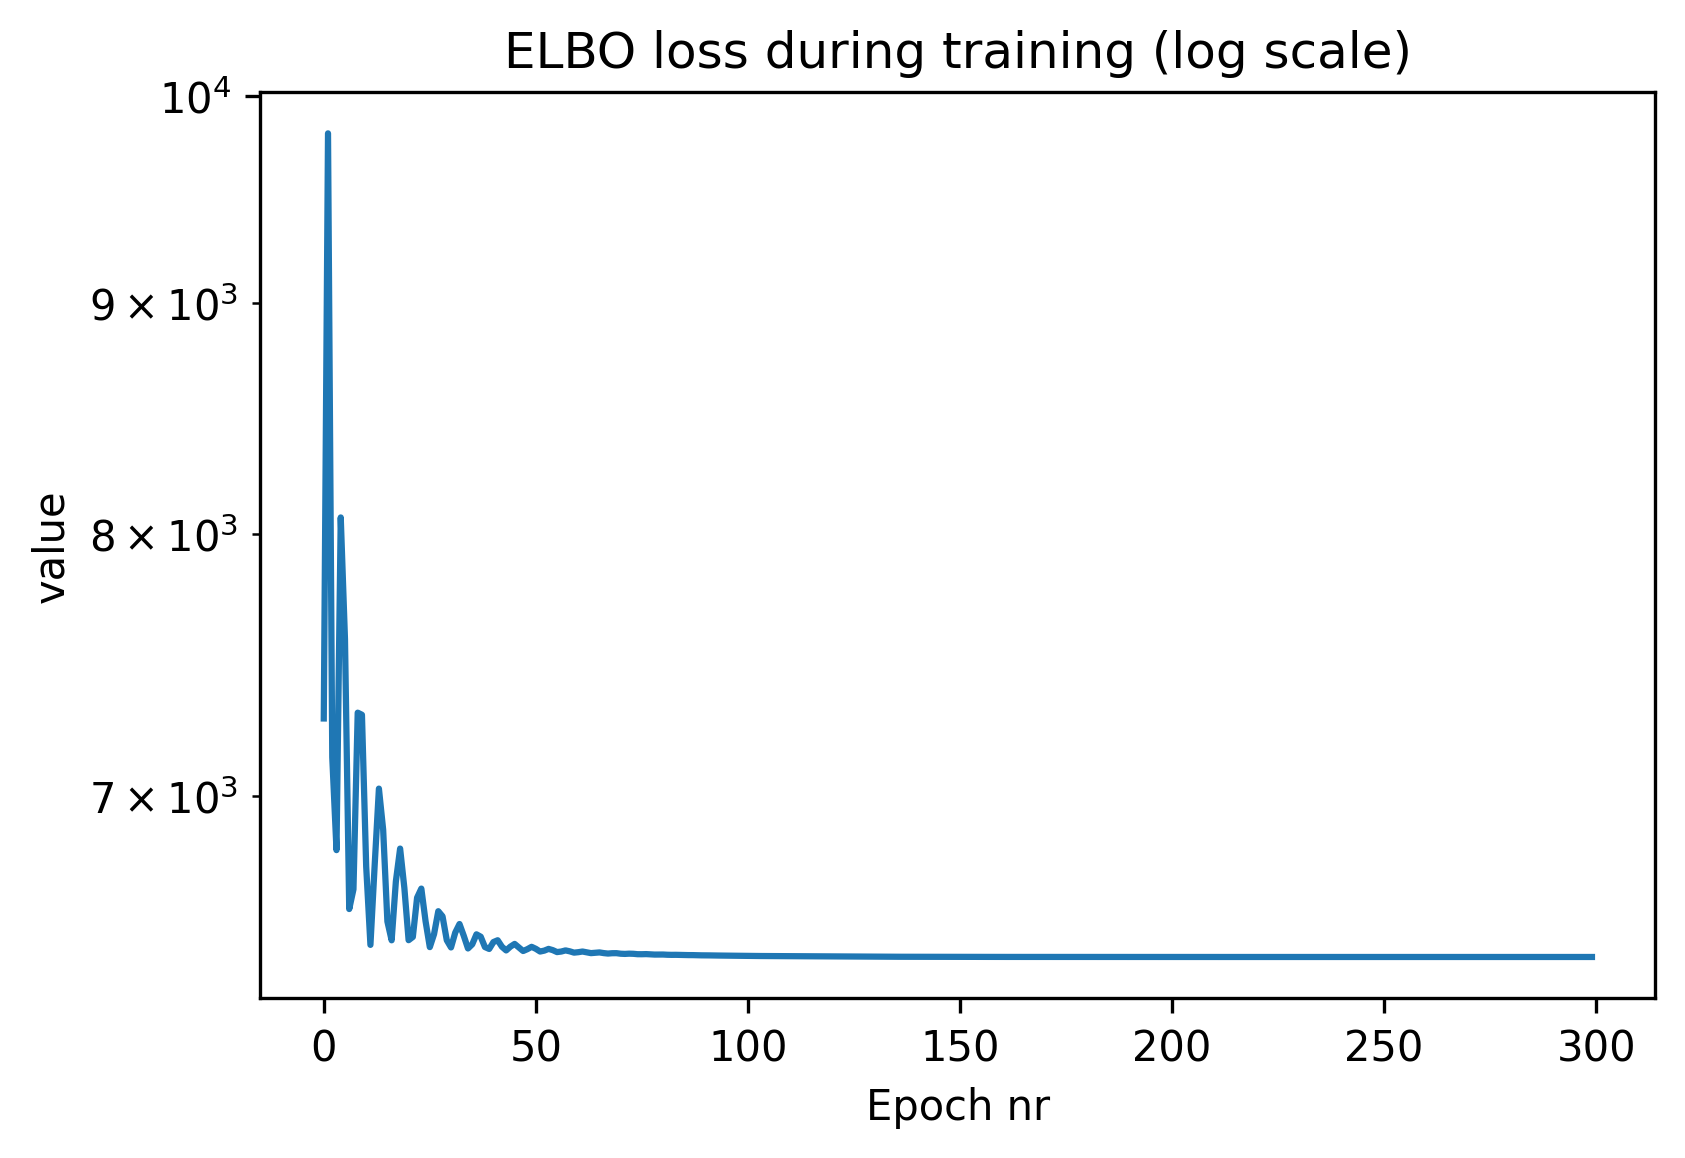

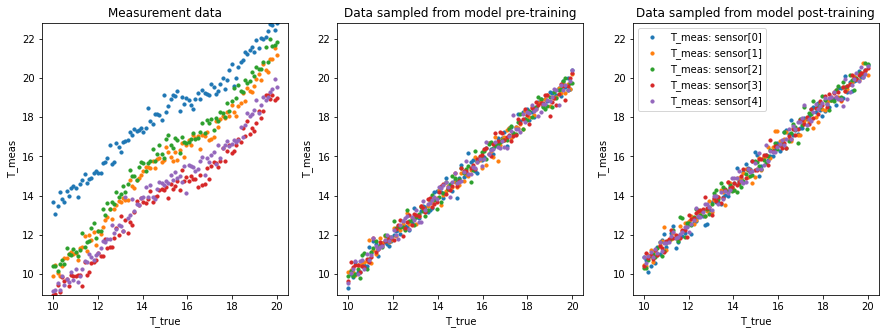

In [6]:
"""
    4. Interpretations and illustrations
"""

# i) Plot and print ELBO loss

# The ELBO is simply the - log evidence = - log probability of the data for
# this simple model. As computed above by the product of Gaussian probability
# density values.
print(' ELBO loss : {} ,\n - log prob of data : {}'.format(loss, -log_prob))

# The training now adjusts the parameters in such a way that the loss decreases.
plt.figure(1, dpi = 300)
plt.plot(loss_sequence)
plt.yscale("log")
plt.title('ELBO loss during training (log scale)')
plt.xlabel('Epoch nr')
plt.ylabel('value')


# ii) Compare model output and data

# Create the figure and 1x5 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)
# Global y-axis limits
y_min = T_meas.min()
y_max = T_meas.max()

# First plot: measurement data
for i in range(n_device):
    axes[0].scatter(T_true[i,:], T_meas[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[0].set_title("Measurement data")
axes[0].set_xlabel("T_true")
axes[0].set_ylabel("T_meas")
axes[0].set_ylim(y_min, y_max)

# Second plot: data produced by model pre-training
for i in range(n_device):
    axes[1].scatter(T_true[i,:], model_data_pretraining[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[1].set_title("Data sampled from model pre-training")
axes[1].set_xlabel("T_true")
axes[1].set_ylabel("T_meas")
axes[1].set_ylim(y_min, y_max)

# Third plot: data produced by model post-training
for i in range(n_device):
    axes[2].scatter(T_true[i,:], model_data_posttraining[i,:], s=10, label=f"T_meas: sensor[{i}]")
axes[2].set_title("Data sampled from model post-training")
axes[2].set_xlabel("T_true")
axes[2].set_ylabel("T_meas")
axes[2].set_ylim(y_min, y_max)
axes[2].legend()

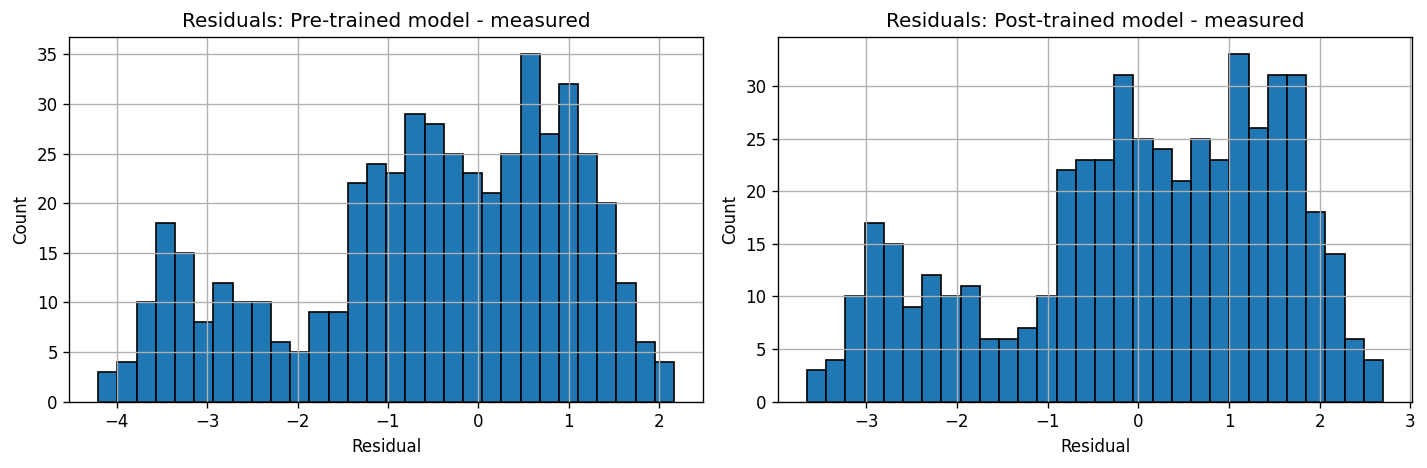

In [7]:
# iii) Illustrate residuals

# compute residuals
residuals_data_pretrain = (T_true - T_meas).detach().numpy()
residuals_data_posttrain = (alpha_0 + alpha_1 * T_true - T_meas ).detach().numpy()

# Residual histograms for model pre- and post-training
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=120)

axes[0].hist(residuals_data_pretrain.flatten(), bins=30, edgecolor='black')
axes[0].set_title("Residuals: Pre-trained model - measured")
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Count")
axes[0].grid(True)

axes[1].hist(residuals_data_posttrain.flatten(), bins=30, edgecolor='black')
axes[1].set_title("Residuals: Post-trained model - measured")
axes[1].set_xlabel("Residual")
axes[1].set_ylabel("Count")
axes[1].grid(True)

plt.tight_layout()
plt.show()


---

## 🧾 Summary

✅ Introduced `pyro.param` for deterministic unknowns  
✅ Used SVI to recover $(\alpha_0,\alpha_1)$ ≈ least-squares solution  
✅ Verified match between Pyro and analytical regression  
✅ Visualised improved fit via ELBO, scatter plots, and residuals  

Next up → latent variables & uncertainty!
